<a href="https://colab.research.google.com/github/yigitkoc04/horizon/blob/main/pneumonia_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount Google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Preamble

In [ ]:
import os
import glob
import h5py
import time
import random
import sklearn.metrics


import numpy as np
import tensorflow as tf



from PIL import Image
from tensorflow import keras 
from tensorflow.keras import layers

In [ ]:
# get the directory that contains data and valuable csv files 
directory = '/content/gdrive/MyDrive/pneumonia'

## Read Datasets

In [ ]:
def ReadH5File(filename, dataset='main'):
  """
  Read an h5 file into memory 

  @param filename: the location of the dataset 
  @param dataset: the location within the dataset 
  """
  with h5py.File(filename, 'r') as hf:
    data = np.array(hf[dataset]) 
    # convert from grayscale to RGB
    return np.repeat(data[..., np.newaxis], 3, -1)

In [ ]:
def GetFilenames(positive_datasets, negative_datasets, target_width, target_height, suffix):
	"""
	Read the positive and negative datasets into training and testing data 

	@param positive_datasets: the datasets that coorespond to positives (y = 1) 
	@param negative_datasets: the datasets the correspond to negatives (y = 0)
	@param target_width: the width of the input data
	@param target_height: the height of the input data
	@param suffix: either 'train' or 'test' depending on the split of the data
	"""
	assert (suffix == 'train' or suffix == 'test')

	# get the training, validation, and testing filenames 
	positive_filenames = []
	negative_filenames = []

	for positive_dataset in positive_datasets:
		positive_filenames += sorted(glob.glob('{}/datasets/{}-{}x{}-{}_X-*.h5'.format(directory, positive_dataset, target_width, target_height, suffix)))
	for negative_dataset in negative_datasets:
		negative_filenames += sorted(glob.glob('{}/datasets/{}-{}x{}-{}_X-*.h5'.format(directory, negative_dataset, target_width, target_height, suffix)))
	
	return positive_filenames, negative_filenames 

In [ ]:
# image size (this should change based on your input network!)
width, height = 224, 224

In [ ]:
# which conditions to train the network on 
positive_datasets = ['VIRAL_PNEUMONIA, BACTERIAL_PNEUMONIA']
negative_datasets = ['NORMAL']

# read the training and testing datasets
positive_filenames, negative_filenames = GetFilenames(positive_datasets, negative_datasets, width, height, 'train')

In [ ]:
def DataGenerator(positive_filenames, negative_filenames, target_width, target_height, batch_size):
  """
  Generate data for the neural network to learn.

  @param positive_filenames: a list of files with positive examples 
  @param negative_filenames: a list of files with negative examples
  @param target_width: the width of the input data
	@param target_height: the height of the input data
  @param batch_size: the number of examples to give at each yield
  """
  # divide the batch size in half (number of positive and negative examples)
  half_batch_size = batch_size // 2

  positive_filename_index = 0
  negative_filename_index = 0

  positive_index = 0
  negative_index = 0
  
  positive_data = ReadH5File(positive_filenames[positive_filename_index])
  negative_data = ReadH5File(negative_filenames[negative_filename_index])
  
  while True:
    # create empty X and y arrays 
    X = np.zeros((0, target_width, target_height, 3), dtype=np.float32)
    y = np.zeros(batch_size, dtype=np.int32)
    
    # add the positive examples to X
    X = np.concatenate((X, positive_data[positive_index:positive_index + half_batch_size]))
    positive_index += half_batch_size
    
    # if all positive_data exhausted, go to the next file 
    if X.shape[0] != half_batch_size:
      positive_filename_index += 1
      if positive_filename_index == len(positive_filenames):
        # rerandomize the array 
        positive_filename_index = 0
        random.shuffle(positive_filenames)
      positive_data = ReadH5File(positive_filenames[positive_filename_index])

      # add the missing data to get to half batch size 
      positive_index = 0
      nexamples = half_batch_size - X.shape[0]
      X = np.concatenate((X, positive_data[positive_index:positive_index + nexamples]))
      positive_index += nexamples
    
    # add the negative examples to X
    X = np.concatenate((X, negative_data[negative_index:negative_index + half_batch_size]))
    negative_index += half_batch_size
    
    # use batch size here since the positive examples are the first half 
    if X.shape[0] != batch_size:
      negative_filename_index += 1
      if negative_filename_index == len(negative_filenames):
        # rerandomize the array 
        negative_filename_index = 0
        random.shuffle(negative_filenames)
      negative_data = ReadH5File(negative_filenames[negative_filename_index])

      # add the missing data to get to full batch size 
      negative_index = 0
      nexamples = batch_size - X.shape[0]
      X = np.concatenate((X, negative_data[negative_index:negative_index + nexamples]))
      negative_index += nexamples
    
    # set the first half of y to 1 (positive)
    y[:half_batch_size] = 1
    
    yield X, y

## CNN Model

In [ ]:
def ConvBlock(model, nfilters):
  """
  Add a convolution block to the model. The block contains two 2D convolutions 
  followed by a max pooling.
  """
  model.add(layers.Conv2D(nfilters, (3, 3), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.001))
  model.add(layers.Conv2D(nfilters, (3, 3), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.001))
  model.add(layers.MaxPool2D((2, 2)))

def Flatten(model):
  """
  Flatten the model into a 1D array.
  """
  model.add(layers.Flatten())

def Dense(model, nfilters, activation):
  """
  Create a dense layer where very input neuron connects to every output neuron.
  """
  model.add(layers.Dense(nfilters))
  model.add(layers.Activation(activation))

In [ ]:
# create a sequential model
model = keras.Sequential()

# add three convolution blocks
ConvBlock(model, 4)
ConvBlock(model, 8)
ConvBlock(model, 8)
ConvBlock(model, 8)
ConvBlock(model, 8)
ConvBlock(model, 16)

# flatten the model 
Flatten(model)
# add three dense layers
Dense(model, 512, 'sigmoid')
Dense(model, 128, 'sigmoid')
Dense(model, 1, 'sigmoid')


In [ ]:
# compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['mse', 'accuracy'])

## Training the Model

In [ ]:
# change this based on the model that you are using
model_prefix = 'SimpleNet'

# create the directory if it doesn't exist 
output_directory = '{}/models/{}'.format(directory, model_prefix)
if not os.path.exists(output_directory):
  os.makedirs(output_directory, exist_ok = True)

checkpoint_path = '{}/POSITIVES-{}-NEGATIVES-{}'.format(output_directory, '-'.join(sorted(positive_datasets)), '-'.join(sorted(negative_datasets)))

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,  monitor="val_loss", save_best_only=True, save_weights_only=True, mode="auto", save_freq="epoch")

# batch size for the network 
batch_size = 10

# there are 250 examples per file
group_size = 250

nvalidation_files = 3
train_positive_filenames = positive_filenames[:-1 * nvalidation_files]
train_negative_filenames = negative_filenames[:-1 * nvalidation_files]

# set the step size for the examples
nexamples_per_epoch = 2 * group_size * max(len(train_positive_filenames), len(train_negative_filenames))
steps_per_epoch = nexamples_per_epoch / batch_size

In [ ]:
validation_positive_filenames = positive_filenames[-1 * nvalidation_files:]
validation_negative_filenames = negative_filenames[-1 * nvalidation_files:]

validation_X = np.zeros((0, width, height, 3), dtype=np.float32)
validation_y = np.zeros((0, ), dtype=np.int32)

for validation_positive_filename in validation_positive_filenames:
  validation_positive_data = ReadH5File(validation_positive_filename)
  validation_X = np.concatenate((validation_X, validation_positive_data), axis = 0)
  validation_y = np.concatenate((validation_y, np.ones((validation_positive_data.shape[0], ))), axis = 0)
for validation_negative_filename in validation_negative_filenames:
  validation_negative_data = ReadH5File(validation_negative_filename)
  validation_X = np.concatenate((validation_X, validation_negative_data), axis = 0)
  validation_y = np.concatenate((validation_y, np.zeros((validation_negative_data.shape[0], ))), axis = 0)

del validation_positive_data
del validation_negative_data

NameError: ignored

In [ ]:
# fit the model to the training data
history = model.fit(DataGenerator(train_positive_filenames, train_negative_filenames, width, height, batch_size), 
                    steps_per_epoch = steps_per_epoch, 
                    epochs = 10, 
                    validation_data = (validation_X, validation_y),
                    callbacks=[checkpoint])

Epoch 1/10
  31/1750 [..............................] - ETA: 19s - loss: 0.6206 - mse: 0.2158 - accuracy: 0.6452

KeyboardInterrupt: ignored

In [ ]:
# print the model summary
model.build((batch_size, width, height, 3))
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, None, None, 4)     112       
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, None, None, 4)     0         
                                                                 
 conv2d_61 (Conv2D)          (None, None, None, 4)     148       
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, None, None, 4)     0         
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, None, None, 4)    0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, None, None, 8)     296       
                                                      

In [ ]:
# load the weights from the best model based on validation loss
model.load_weights(checkpoint_path)

## Evaluate Results

In [ ]:
def EvaluateModel(model, positive_filenames, negative_filenames):
  """
  Evaluate the model with the dataset X and labels y 

  @param model: the machine learned model
  @param positive_filenames: locations of the positive examples
  @param negative_filenames: locations of the negative examples
  """
  true_positive = False 
  true_negative = False 
  false_positive = False 
  false_negative = False 

  # create a vector for the ground truth and predictions 
  ground_truth = np.zeros((0, 1), dtype=np.int32)
  predictions = np.zeros((0, 1), dtype=np.float32)
  for filename in positive_filenames + negative_filenames:
    data = ReadH5File(filename)
    
    predictions = np.concatenate((predictions, model.predict(data, batch_size = group_size)))

    if filename in positive_filenames:
      ground_truth = np.concatenate((ground_truth, np.ones((data.shape[0], 1))))
    else:
      ground_truth = np.concatenate((ground_truth, np.zeros((data.shape[0], 1))))

    for iv in range(data.shape[0]):
      label = (filename in positive_filenames)
      prediction = (predictions[len(predictions) - group_size + iv] > 0.5)

      if not true_positive and label and prediction:
        print ('True Positive')
        example = Image.fromarray(data[iv,:,:,:])
        display(example)
        
        true_positive = True

      if not true_negative and not label and not prediction:
        print ('True Negative')
        example = Image.fromarray(data[iv,:,:,:])
        display(example)
        
        true_negative = True

      if not false_positive and not label and prediction:
        print ('False Positive')
        example = Image.fromarray(data[iv,:,:,:])
        display(example)
        
        false_positive = True
  
      if not false_negative and label and not prediction:
        print ('False Negative')
        example = Image.fromarray(data[iv,:,:,:])
        display(example)
        
        false_negative = True

  confusion_matrix = sklearn.metrics.confusion_matrix(ground_truth, (predictions > 0.5))
  
  true_positives = confusion_matrix[1,1]
  true_negatives = confusion_matrix[0,0]
  false_positives = confusion_matrix[0,1]
  false_negatives = confusion_matrix[1,0]
  nexamples = len(predictions)

  precision = true_positives / (true_positives + false_positives)
  recall = true_positives / (true_positives + false_negatives)

  # print valuable statistical information
  print ('  True Positives: {}'.format(true_positives))
  print ('  True Negatives: {}'.format(true_negatives))
  print ('  False Positives: {}'.format(false_positives))
  print ('  False Negatives: {}'.format(false_negatives))
  print ('  Accuracy: {:0.4f}'.format((true_positives + true_negatives) / nexamples))
  print ('  Precision: {:0.4f}'.format(precision))
  print ('  Recall: {:0.4f}'.format(recall))
  print ('  F1-Score: {:0.4f}'.format(2 * precision * recall / (precision + recall)))
  print ('  AUC: {:0.4f}'.format(sklearn.metrics.roc_auc_score(ground_truth, predictions)))

  

Testing data
True Positive


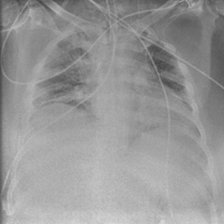

False Negative


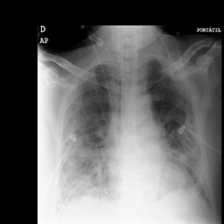

True Negative


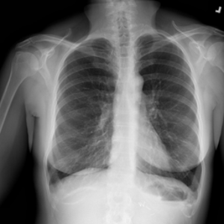

False Positive


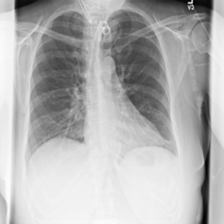

  True Positives: 692
  True Negatives: 2125
  False Positives: 230
  False Negatives: 31
  Accuracy: 0.9152
  Precision: 0.7505
  Recall: 0.9571
  F1-Score: 0.8413
  AUC: 0.9822


In [ ]:
# training data
#print ('Training data')
#EvaluateModel(model, train_positive_filenames, train_negative_filenames)
# testing data
#print ('Validation data')
#EvaluateModel(model, validation_positive_filenames, validation_negative_filenames)
print ('Testing data')
test_positive_filenames, test_negative_filenames = GetFilenames(positive_datasets, negative_datasets, width, height, 'test')
EvaluateModel(model, test_positive_filenames, test_negative_filenames)